In [1]:
from lib.opt_types import *
from lib.utils import *
from lib.part_one import f, f_full_data, x_zero

# Stochastic gradient methods - 30 Points


In this problem, you will implement three different versions of stochastic gradient descent to solve the logistic regression problem on the entire NBA dataset.

In order to use the stochastic gradient descent methods, we recast our estimation problem (3) as follows,

$$
f(\mathbf{x}) = \frac{1}{n}\sum_{i=1}^n\bigg\{\underbrace{\log(1 + \exp(- b_i \mathbf{a}_i^T\mathbf{x})) + \frac{\mu}{2}\|\mathbf{x}\|^2}_{f_i(\mathbf{x})}\bigg\},
$$

where we for notational convenience suppress the dependency on $\mu$.
As we saw in Problem 1, we have that

$$
\nabla f_i(\mathbf{x}) = -b_i \sigma(-b_i \cdot \mathbf{a}_i^T\mathbf{x})\mathbf{a}_i + \mu \mathbf{x}.
$$

The objective function can be written as a sum of $n$ terms. We augment the `Function` type introduced in previous notebooks to include the following attributes:

- To access the gradient of the `j`-th term at a point `x` you can write `f.i_grad(j, x)`.
- The number of terms $n$ is stored in the attribute `f.n`. 

Consider the following stochastic gradient update: At the iteration $k$, pick $i_k\in\{1, \ldots, n\}$ uniformly at random and define

$$
\mathbf{x}^{k+1} :=  \mathbf{x}^k - \alpha_k\nabla{f}_{i_k}(\mathbf{x}^k).
$$

__(a)__ (2 points) Show that $\nabla f_{i_k}(\mathbf{x})$ is an unbiased estimation of $\nabla f(\mathbf{x})$. Explain why $\nabla f_{i_k}$ is Lipschitz continuous with $L(f_{i_k}) = \|\mathbf{a}_{i_k}\|^2+ \mu $. 

__Hint__: Recall how we computed $L$ in Problem 1. In the following, we will set $L_{\max} = \max_{i\in\{1, \ldots, n\}}L(f_i)$.

### Solution

Let
$$
f(\mathbf{x})=\frac{1}{n}\sum_{i=1}^n f_i(\mathbf{x}),\qquad
f_i(\mathbf{x})=\log\!\big(1+e^{-\,b_i\,\mathbf{a}_i^\top \mathbf{x}}\big)\;+\;\frac{\mu}{2}\|\mathbf{x}\|^2,
$$
so that
$$
\nabla f_i(\mathbf{x})
= -\,b_i\,\sigma(-\,b_i\,\mathbf{a}_i^\top \mathbf{x})\,\mathbf{a}_i \;+\; \mu\,\mathbf{x},
\qquad
\sigma(t)=\frac{1}{1+e^{-t}}.
$$

---

#### Unbiasedness
Pick $i_k$ uniformly from $\{1,\ldots,n\}$. Then
$$
\mathbb{E}\!\left[\nabla f_{i_k}(\mathbf{x})\right]
= \frac{1}{n}\sum_{i=1}^n \nabla f_i(\mathbf{x})
= \nabla\!\left(\frac{1}{n}\sum_{i=1}^n f_i(\mathbf{x})\right)
= \nabla f(\mathbf{x}).
$$
Hence $\nabla f_{i_k}(\mathbf{x})$ is an unbiased estimator of the full gradient.

---

#### Lipschitz continuity of $\nabla f_i$
Compute the Hessian of a single term. Let $s_i=\sigma(-\,b_i\,\mathbf{a}_i^\top \mathbf{x})\in(0,1)$. Then
$$
\nabla^2 f_i(\mathbf{x})
= s_i(1-s_i)\,\mathbf{a}_i\mathbf{a}_i^\top \;+\; \mu\,\mathbf{I}.
$$
Using $\|\mathbf{a}_i\mathbf{a}_i^\top\|_2=\lambda_{\max}(\mathbf{a}_i\mathbf{a}_i^\top)=\|\mathbf{a}_i\|_2^2$ (rank-one)
and $s_i(1-s_i)\le 1$ (tighter: $\le \tfrac14$), we get the uniform bound
$$
\|\nabla^2 f_i(\mathbf{x})\|_2
\;\le\; s_i(1-s_i)\,\|\mathbf{a}_i\|_2^2+\mu
\;\le\; \|\mathbf{a}_i\|_2^2+\mu
\qquad \text{for all }\mathbf{x}.
$$
A uniform bound on the Hessian implies a Lipschitz gradient (w.r.t. the Frobenius/Euclidean norm):
$$
\|\nabla f_i(\mathbf{x})-\nabla f_i(\mathbf{y})\|_F
\;\le\; (\|\mathbf{a}_i\|_2^2+\mu)\,\|\mathbf{x}-\mathbf{y}\|_F.
$$
Therefore $\nabla f_{i_k}$ is $L(f_{i_k})$-Lipschitz with
$$
\boxed{\,L(f_{i_k})=\|\mathbf{a}_{i_k}\|_2^2+\mu\, }.
$$


__(b)__ (2 points) 
We can use the standard stochastic gradient descent method SGD to solve the problem above.
Implement `SGD` by completing the following cells with $\alpha_k =\frac{0.01}{k}$.

**Hint**: For some `N`, the function `np.random.choice(N)` generates a random integer in $\{0, \dots, N-1 \}$.


In [2]:
@dataclass
class SGD_state(OptState):
    x_k: Vector
    k: int

In [3]:
def SGD_update(f, state):
    x_k, k = state

    i_k = np.random.choice(f.n)

    alpha_k = 0.01 / k
    next_x_k = x_k - alpha_k * f.i_grad(i_k, x_k)

    return SGD_state(next_x_k, k + 1)

def SGD_initialize(f, x_zero):
    return SGD_state(x_zero, 1)


In [4]:
SGD = OptAlgorithm(name="SGD", init_state=SGD_initialize, state_update=SGD_update)

__(c)__ (6 points) 
Consider the following stochastic averaging gradient method SAG to solve the problem above:

$$
\begin{aligned}
&\text{pick } i_k\in\{1, \ldots, n\} \text{ uniformly at random}\\
&\mathbf{x}^{k+1} := \mathbf{x}^k - \frac{\alpha_k}{n}\sum_{i=1}^n\mathbf{v}_i^k,
\end{aligned}
$$

where 

$$
\mathbf{v}_i^k =
\begin{cases}
\nabla f_i(\mathbf{x}^k) &\text{if}\, i = i_k,\\
\mathbf{v}_i^{k-1} &\text{otherwise}.
\end{cases}
$$

Implement `SAG` by completing the following cells using the step-size 
$\alpha_k=\frac{0.01}{L_{\max}}$ and $\mathbf{v}^0=\mathbf{0}$. (Note that you can access $L_{\max}$ by writing `f.L_max`. 

In [5]:
@dataclass
class SAG_state(OptState):
    x_k: Vector
    v_k: List[Vector]
    alpha_k: float

In [6]:
def SAG_update(f, state):
    x_k, v_k, alpha_k = state

    # pick an index uniformly at random
    i_k = np.random.choice(f.n)

    # refresh the chosen component's gradient
    g_i = f.i_grad(i_k, x_k)
    v_k = list(v_k)          # copy to avoid aliasing
    v_k[i_k] = g_i

    # compute the average of stored gradients
    grad_avg = sum(v_k) / f.n

    # gradient step with constant stepsize alpha_k = 0.01 / f.L_max
    next_x_k = x_k - alpha_k * grad_avg

    return SAG_state(next_x_k, v_k, alpha_k)

def SAG_initialize(f, x_zero):
    alpha_k = 0.01 / f.L_max
    v0 = [np.zeros_like(x_zero) for _ in range(f.n)]
    return SAG_state(x_zero, v0, alpha_k)


In [7]:
SAG = OptAlgorithm(name="SAG", init_state=SAG_initialize, state_update=SAG_update)

SAG    : 100%|██████████| 500000/500000 [1:00:57<00:00, 136.70it/s]


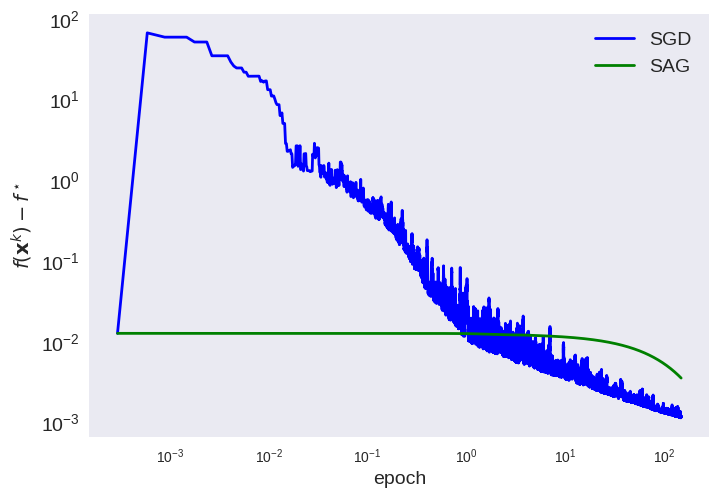

In [8]:
plot_epochs([SGD, SAG], f, x_zero, 500000)

__(d)__ (6 points) 
We can improve the convergence rate of SGD by periodically computing the full gradient. `SVRG` uses the following variance reduction scheme:

$$
\begin{aligned}
&\text{if } k = 0 \text{ mod } q:\\
&\quad \mathbf{z} = \mathbf{x}^k\\
&\quad \tilde{\mathbf{v}} = \nabla f(\mathbf{x}^k)\\
&\text{Pick } i_k\in \{1, \ldots, n\} \text{ uniformly at random}\\
&\mathbf{d}^k = \nabla f_{i_k}({\mathbf{x}}^k) - \nabla f_{i_k}(\mathbf{z}) + \tilde{\mathbf{v}}\\
&{\mathbf{x}}^{k+1} := {\mathbf{x}}^k - \gamma\mathbf{d}^k
\end{aligned}
$$

Implement `SVRG` by completing the following cells and fixing the following constant:
$\gamma = 1/L_{\max}$ and $q = 100$. 

In [9]:
@dataclass
class SVRG_state(OptState):
    x_k: Vector 
    z: Vector
    tilde_v: Vector
    q: int
    gamma: float
    k: int

In [10]:
def SVRG_update(f, state):
    x_k, z, tilde_v, q, gamma, k = state

    # refresh snapshot and full gradient every q iterations
    if k % q == 0:
        z = x_k
        tilde_v = f.grad(z)

    # sample an index and build the variance-reduced direction
    i_k = np.random.choice(f.n)
    d_k = f.i_grad(i_k, x_k) - f.i_grad(i_k, z) + tilde_v

    # update
    next_x_k = x_k - gamma * d_k

    return SVRG_state(next_x_k, z, tilde_v, q, gamma, k + 1)

def SVRG_initialize(f, x_zero):
    q = 100
    gamma = 1.0 / f.L_max
    z = x_zero
    tilde_v = f.grad(z)
    return SVRG_state(x_zero, z, tilde_v, q, gamma, 0)


In [11]:
SVRG = OptAlgorithm(name="SVRG", init_state=SVRG_initialize, state_update=SVRG_update)

__(e)__ (8 points) Another variance reduction method is `SARAH`. The scheme can be described as follows:

$$
\begin{aligned}
&\text{if } k = 0 \text{ mod } q:\\
&\quad {\mathbf{x}}^k = {\mathbf{z}}\\
&\quad {\mathbf{v}}^k = \nabla f({\mathbf{z}})\\
&\quad t \in \{0, \ldots, q-1\} \text{ uniformly at random}\\
&\text{if } k = t \text{ mod } q:\\
&\quad {\mathbf{z}} = {\mathbf{x}}^{k}\\
&\text{Pick } i_k\in \{1, \ldots, n\} \text{ uniformly at random}\\
&{\mathbf{v}}^{k+1} = \nabla f_{i_k}({\mathbf{x}}^k) - \nabla f_{i_k}({\mathbf{x}^{k-1}}) + {\mathbf{v}}^{k}\\
&{\mathbf{x}}^{k+1} := {\mathbf{x}}^k - \gamma {\mathbf{v}}^{k+1}
\end{aligned}
$$


Implement `SARAH` by completing the following cells. Pick `q=100` and $\gamma = \frac{1}{L_{\max}}$.

In [12]:
@dataclass
class SARAH_state(OptState):
    x_k: Vector 
    prev_x_k: Vector
    v_k: Vector
    z: Vector
    q: int
    t: int
    gamma: float
    k: int

In [13]:
def SARAH_update(f, state):
    x_k, prev_x_k, v_k, z, q, t, gamma, k = state

    # restart every q steps
    if k % q == 0:
        x_k = z
        v_k = f.grad(z)
        t = np.random.choice(q)  # choose refresh offset for z in this epoch

    # refresh the snapshot z once per epoch at iteration k = t (mod q)
    if k % q == t:
        z = x_k

    # sample index and build SARAH direction
    i_k = np.random.choice(f.n)
    v_next = f.i_grad(i_k, x_k) - f.i_grad(i_k, prev_x_k) + v_k

    # gradient step
    x_next = x_k - gamma * v_next

    return SARAH_state(x_next, x_k, v_next, z, q, t, gamma, k + 1)

def SARAH_initialize(f, x_zero):
    q = 100
    gamma = 1.0 / f.L_max
    z = x_zero
    v0 = f.grad(z)
    return SARAH_state(x_zero, x_zero, v0, z, q, 0, gamma, 0)


In [14]:
SARAH = OptAlgorithm(name="SARAH", init_state=SARAH_initialize, state_update=SARAH_update)

__(f)__ (6 points) Another variance reduction method is `Spider`. The scheme can be described as follows:

$$
\begin{aligned}
&\text{if } k = 0 \text{ mod } q:\\
&\quad {\mathbf{v}}^k = \nabla f({\mathbf{x}}^k)\\
&\text{if } k \neq 0 \text{ mod } q:\\
&\quad \text{Pick } i_k\in \{1, \ldots, n\} \text{ uniformly at random}\\
&\quad {\mathbf{v}}^k = \nabla f_{i_k}({\mathbf{x}}^k) - \nabla f_{i_k}({\mathbf{x}}^{k-1}) + {\mathbf{v}}^{k-1}\\
&\eta := \min \big(\frac{1}{\left \| {\mathbf{v}}^{k} \right \|_2}, \frac{1}{\epsilon}\big)\\
&{\mathbf{x}}^{k+1} := {\mathbf{x}}^k - \gamma \eta {\mathbf{v}}^{k}
\end{aligned}
$$


Implement `Spider` by completing the following cells. Pick `q=100`, $\epsilon = 0.05$ and $\gamma = \frac{1}{L_{\max}}$.

In [15]:
@dataclass
class Spider_state(OptState):
    x_k: Vector 
    prev_x_k: Vector
    prev_v_k: Vector
    q: int
    gamma: float
    k: int
    epsilon: float

In [16]:
import numpy as np
from numpy.linalg import norm

def Spider_update(f, state):
    x_k, prev_x_k, prev_v_k, q, gamma, k, epsilon = state

    # compute SPIDER direction
    if k % q == 0:
        v_k = f.grad(x_k)  # full gradient at the start of each epoch
    else:
        i_k = np.random.choice(f.n)
        v_k = f.i_grad(i_k, x_k) - f.i_grad(i_k, prev_x_k) + prev_v_k

    # adaptive scaling
    nv = norm(v_k)
    eta = min((1.0 / nv) if nv > 0 else np.inf, 1.0 / epsilon)

    # gradient step
    next_x_k = x_k - gamma * eta * v_k

    return Spider_state(next_x_k, x_k, v_k, q, gamma, k + 1, epsilon)

def Spider_initialize(f, x_zero):
    q = 100
    gamma = 1.0 / f.L_max
    epsilon = 0.05
    return Spider_state(x_zero, x_zero, np.zeros_like(x_zero), q, gamma, 0, epsilon)



In [17]:
Spider = OptAlgorithm(name="Spider", init_state=Spider_initialize, state_update=Spider_update)

Spider : 100%|██████████| 50000/50000 [00:53<00:00, 938.46it/s]


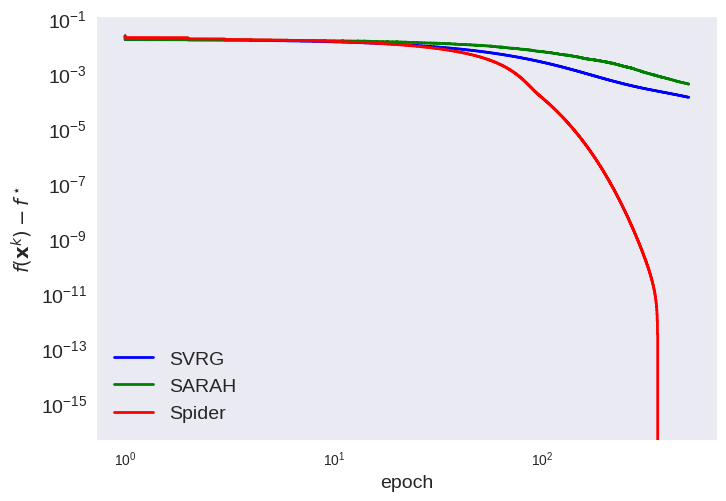

In [18]:
plot_epochs([SVRG, SARAH, Spider], f_full_data, x_zero, 50000)